Run DGA without the cutoff on R232 distance

In [1]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as ppl

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [8]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4150115, 3)


In [9]:
hb_trajs = list(np.load("../../data/raw_feat/hbonds.npy", allow_pickle=True))
hb_trajs.extend(np.load("../../data/raw_feat/hbonds_anton2.npy", allow_pickle=True))
hb_arr = np.concatenate(hb_trajs)
print(hb_arr.shape)

(4150115, 18)


In [10]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

# Distance basis

In [11]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
# sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    # & (sb5 < 0.6)
)

In [12]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [13]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  37852
Number of up structures:   9136
Number of other structures: 4103127


In [14]:
random.seed(123)

In [15]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

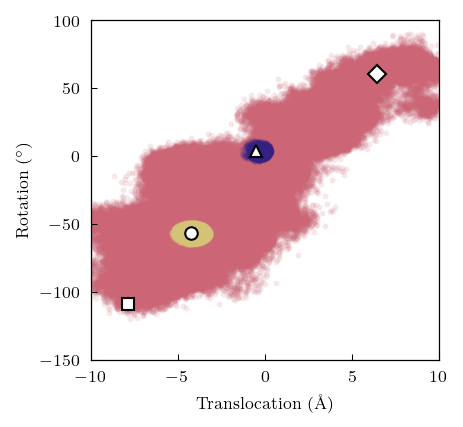

In [16]:
plt.scatter(other_cvs[::10, 0], other_cvs[::10, 1], alpha=0.1)
plt.scatter(up_cvs[::10, 0], up_cvs[::10, 1], alpha=0.1)
plt.scatter(down_cvs[::10, 0], down_cvs[::10, 1], alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

## compute distance to states

In [17]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [19]:
d_up = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, up[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.35% completed
0.71% completed
1.06% completed
1.42% completed
1.77% completed
2.12% completed
2.48% completed
2.83% completed
3.19% completed
3.54% completed
3.89% completed
4.25% completed
4.60% completed
4.96% completed
5.31% completed
5.66% completed
6.02% completed
6.37% completed
6.73% completed
7.08% completed
7.43% completed
7.79% completed
8.14% completed
8.50% completed
8.85% completed
9.20% completed
9.56% completed
9.91% completed
10.27% completed
10.62% completed
10.97% completed
11.33% completed
11.68% completed
12.04% completed
12.39% completed
12.74% completed
13.10% completed
13.45% completed
13.81% completed
14.16% completed
14.51% completed
14.87% completed
15.22% completed
15.58% completed
15.93% completed
16.28% completed
16.64% completed
16.99% completed
17.35% completed
17.70% completed
18.05% completed
18.41% completed
18.76% completed
19.12% completed
19.47% completed
19.82% completed
20.18% completed
20.53% completed
20.89% completed
21.24% completed
21.59% c

In [20]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

(4150115, 1)


In [17]:
d_down_arr = np.load("../../data/feat2_dist_du_anton2/dist_down_3.npy")
# np.save("../../data/feat2_dist_du_anton2/dist_up_nor4", d_up_arr)
d_up_arr = np.load("../../data/feat2_dist_du_anton2/dist_up_nor4.npy")

## Basis and smoothing

In [18]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [19]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(4150115, 1) (4150115, 1) (4150115, 1)


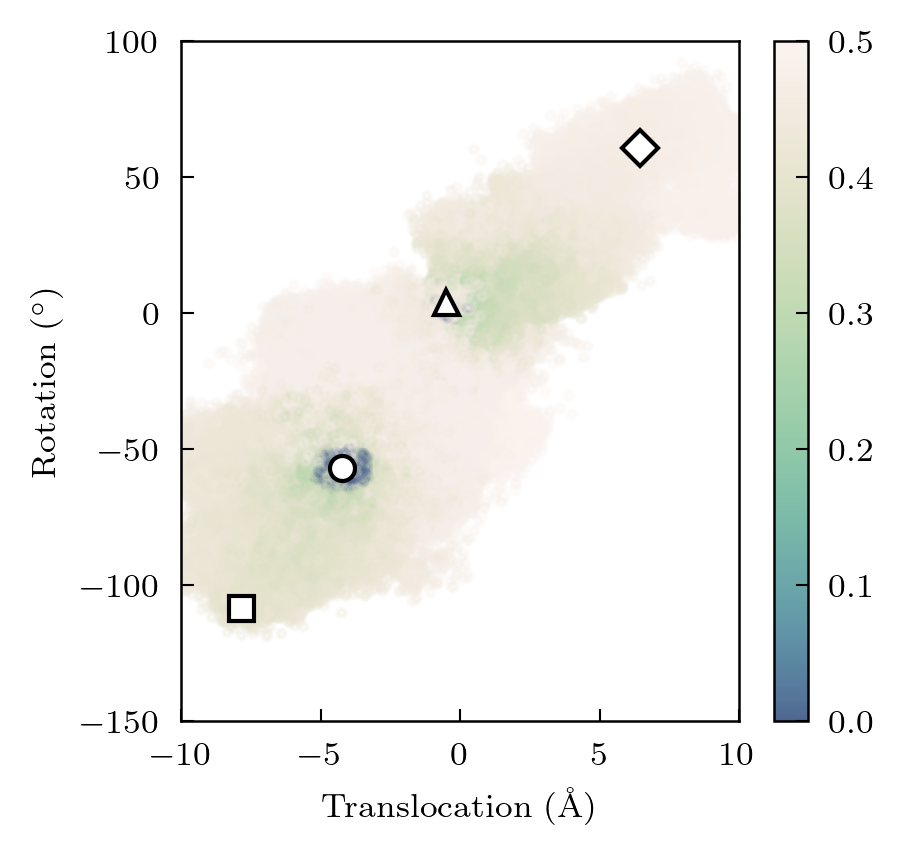

In [20]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=300)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2, cmap=cm_seq)
# h = ax.scatter(cv_arr[3_000_000:, 0], cv_arr[3_000_000:, 1], c=smooth[3_000_000:], alpha=0.2, cmap=cm_seq)

cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

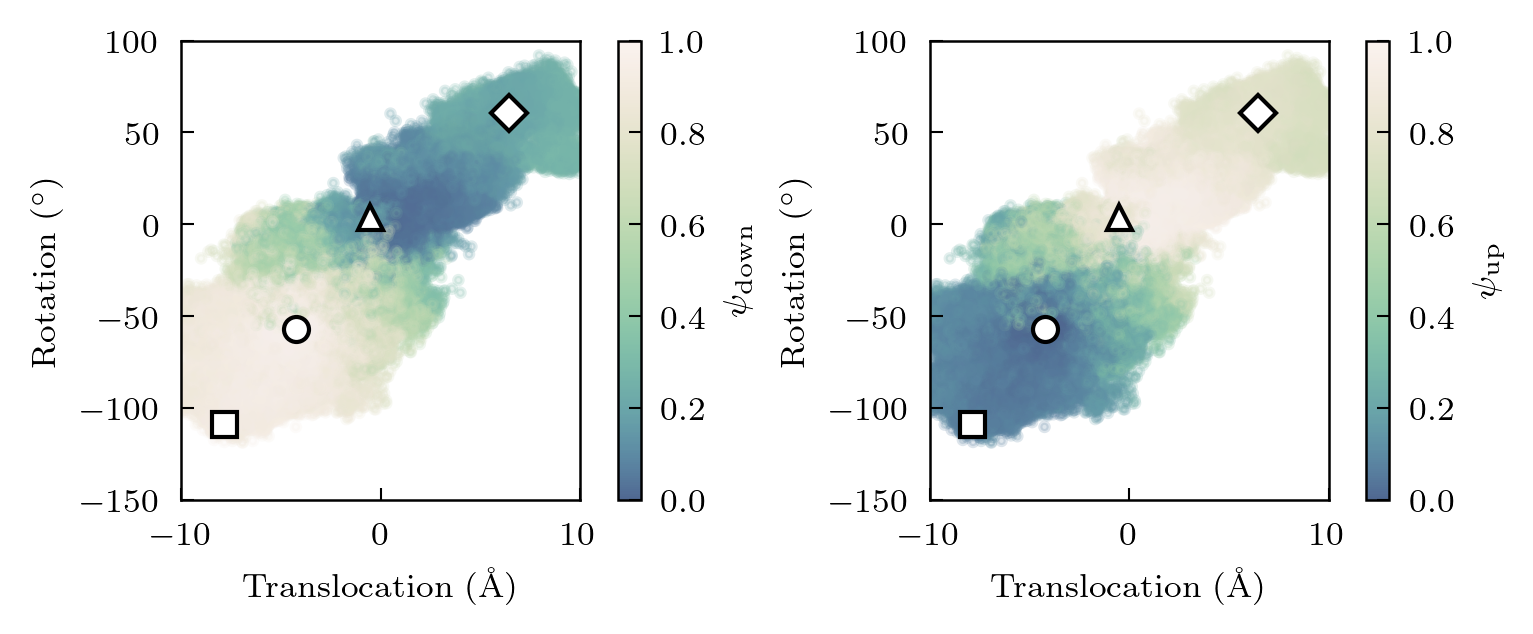

In [25]:
# Plot down and up state guess function
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=300, constrained_layout=True)
labels = ("$\psi_{\mathrm{down}}$", "$\psi_{\mathrm{up}}$")
for ax, g, label in zip(axs, (guess_down, guess_up), labels):
    h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=g[inds], alpha=0.2, cmap=cm_seq)
    cb = plt.colorbar(h, ax=ax, label=label)
    cb.solids.set(alpha=1.0)
    plotting.format_cvs(ax, ms=6)

In [21]:
# weights
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

In [22]:
traj_inds = util.split_indices(cv_trajs)
guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(guessU))
print(len(guessD))

352
352


# Committors

## Basis

In [23]:
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
traj_lens = [len(t) for t in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])

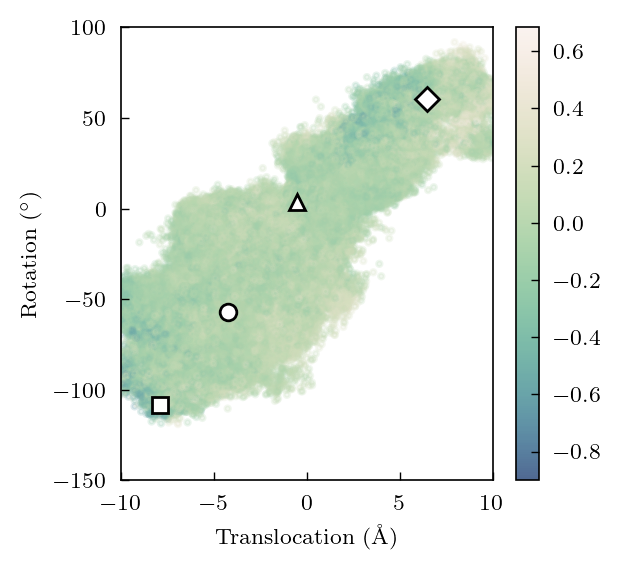

In [24]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(
    cv_arr[inds, 0],
    cv_arr[inds, 1],
    c=np.mean(np.concatenate(basis_d), axis=-1)[inds],
    alpha=0.2,
    cmap=cm_seq,
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [25]:
assert np.all(np.concatenate(basis_d)[~mask] == False)

## Calculations

In [26]:
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [27]:
# lag = 50 ns
qp = extq.dga.forward_committor(basis_d, weights[8], in_domain, guessU, 500)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


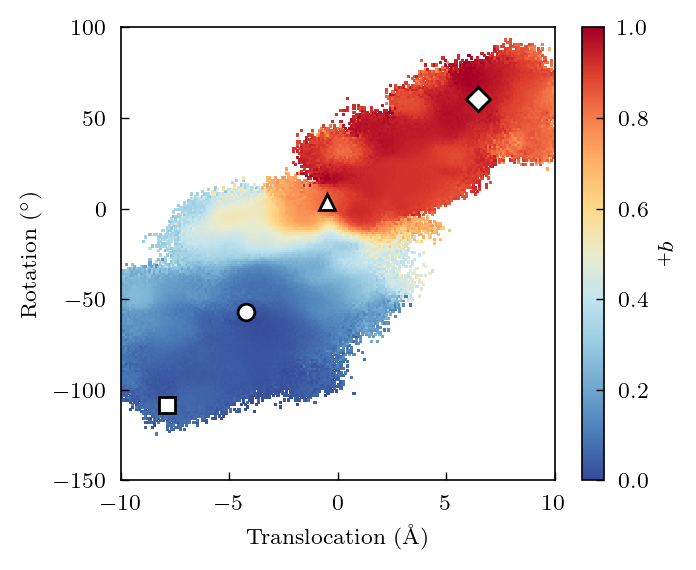

In [30]:
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
q_dens = extq.projection.average2d(
    dist_trajs, rot_trajs, qp, weights[0], xe, ye
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

In [33]:
from extq.stop import forward_stop

In [38]:
# compute E[\theta(x) S_tq_+(x)]
lag = 500
w_delay = [w[:-lag] for w in weights[0]]
qp_delay = []
for d, t in zip(in_domain, qp):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

In [35]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\varepsilon$")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/3997850/ipykernel_3930702/3843493940.py:20: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fa32bc33c70> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])


[(3.0, 16.0), (3.0, 16.0)]

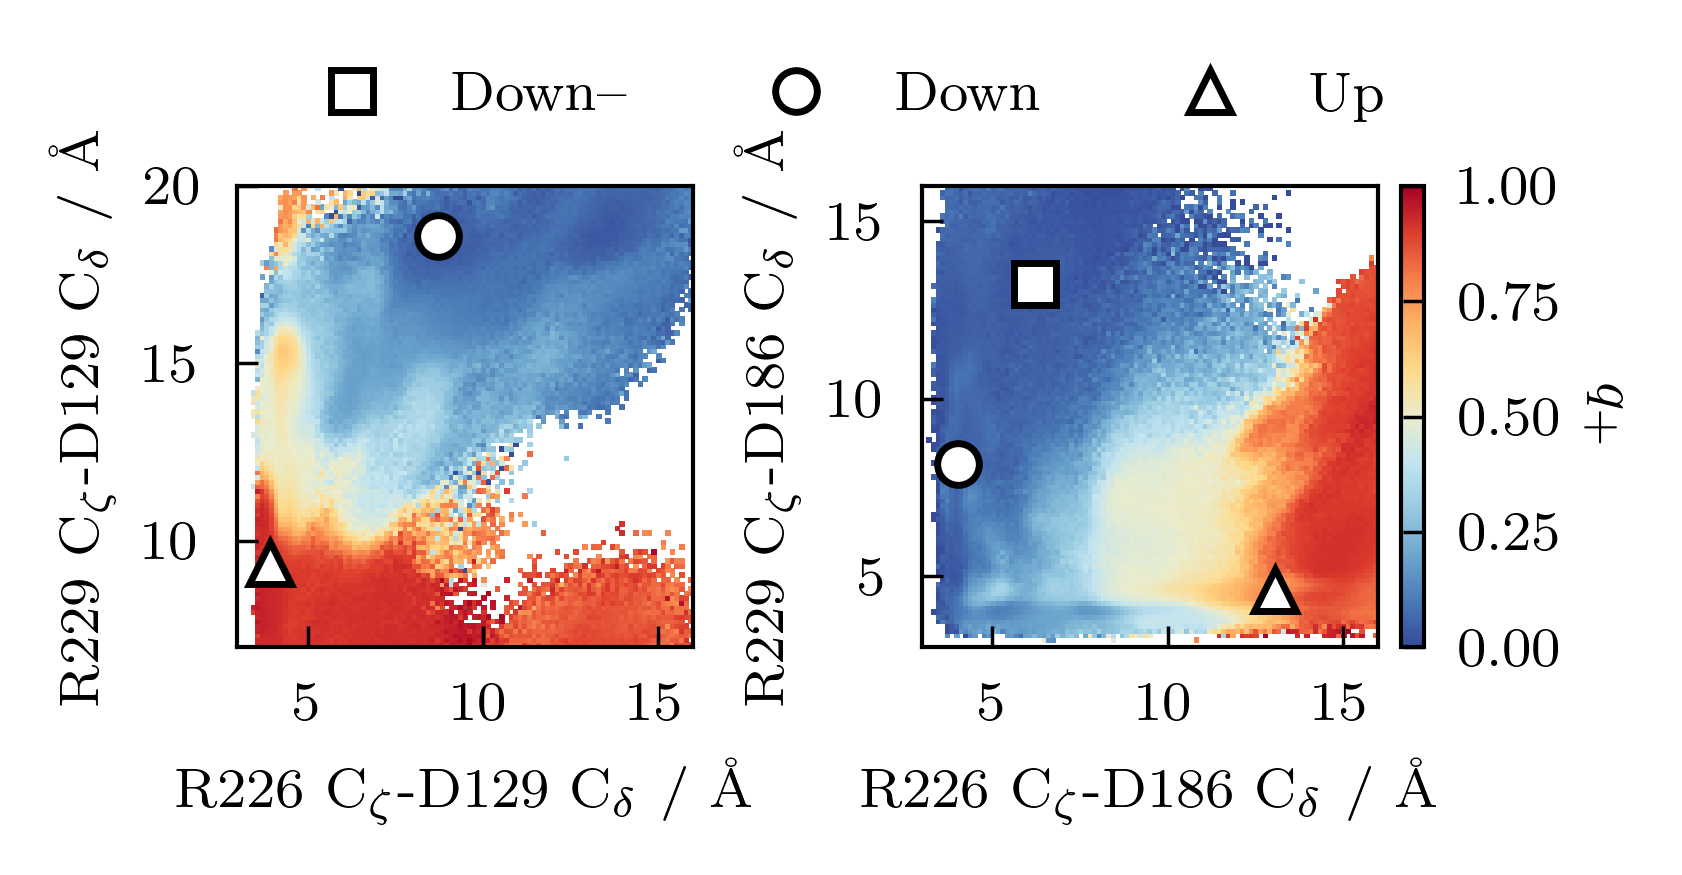

In [39]:
f, axes = plt.subplots(1, 2, figsize=(3.25, 1.4), dpi=500, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
for ((sb1, sb2), ax, r) in zip(((42, 48), (47, 53)), axes, (range0, range1)):
    sb1_trajs = [t[:-lag, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:-lag, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    q_dens = extq.projection.average2d(sb1_trajs, sb2_trajs, qp_delay, w_delay, xlim, ylim)
    h = ax.pcolor(xlim, ylim, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )
    
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

f.legend(bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3, labels=["_blank", 'Down–', 'Down', 'Up'])
cb = plt.colorbar(h, ax=axes[-1])
cb.solids.set(alpha=1)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
axes[0].set(xlim=range0[0], ylim=range0[1])
axes[1].set(xlim=range1[0], ylim=range1[1])

# LASSO 

In [41]:
# no c-alpha distances
X = np.hstack((cv_arr, sb_arr[:, 30:], rf161_arr))
y = np.concatenate(qp)
print(X.shape, y.shape)

(4150115, 35) (4150115,)


In [42]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\varepsilon$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

# LASSO

In [48]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [44]:
def run_lasso(data, q, alpha=0.1, fit_intercept=True):
    model = Lasso(alpha=alpha, fit_intercept=False)
    model.fit(data, q)
    recon = model.predict(data)
    beta = model.coef_
    intercept = model.intercept_
    score = model.score(data, q)
    return recon, beta, intercept, score

In [49]:
w_arr = np.concatenate(weights[0])
cutoff = 0.2
nsamp = 100000
# take points at transition region
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
# weight by committor value
mid_weight = w_arr[mid_idx] * y[mid_idx] * (1 - y[mid_idx])
mid_weight /= np.sum(mid_weight)
idx = np.random.choice(mid_idx, size=min(nsamp,len(mid_idx)), p=mid_weight, replace=False)
# inverse sigmoid transform
logit_q = np.log(y[idx] / (1 - y[idx]))
# apply standardization
std_scale = StandardScaler()
X_trans = std_scale.fit_transform(X[idx])

In [50]:
# compute coefficients as a function of regularization strength
coeffs_all = []
r2_all = []
for a in np.linspace(0.02, 0.30, 15):
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    coeffs_all.append(coeffs)
    r2_all.append(r2)

In [52]:
feature_colors = ["grey", "#E46C0A", "#51BD52", "#D85BD8", "#5AA5A5", "#0000FF", "#ffcc00"]

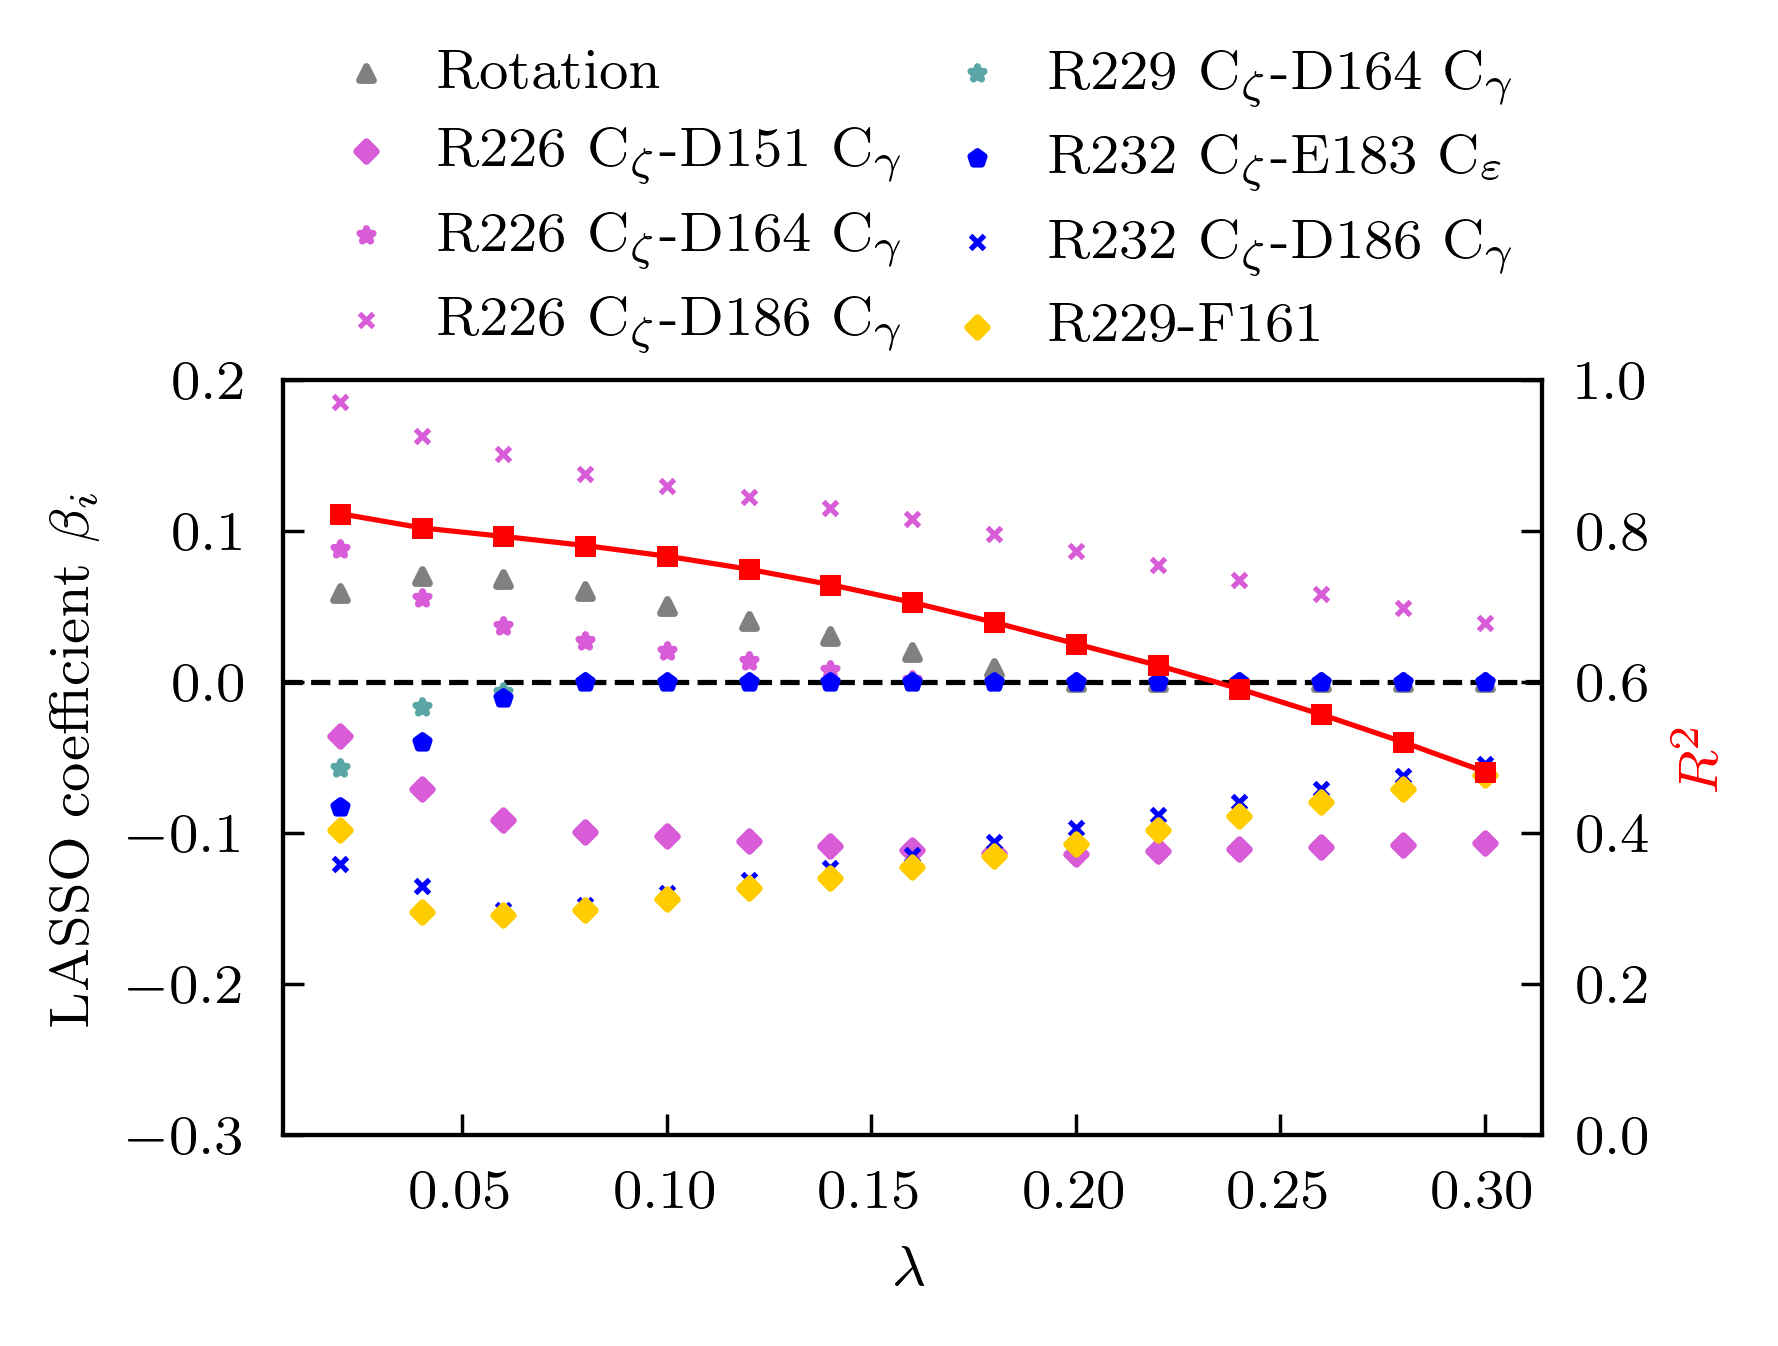

In [54]:
f = plt.figure(figsize=(3.25, 2), dpi=500)
ax = plt.gca()

ax2 = plt.twinx()
alphas = np.linspace(0.02, 0.30, 15)
ax2.plot(alphas, r2_all, '-s', color='r', zorder=1)
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.0, 1.0])

coeffs_all = np.array(coeffs_all)
cc = []
markers = list('o^D*px')
cc.append(dict(color=feature_colors[0], marker=markers[0]))
cc.append(dict(color=feature_colors[0], marker=markers[1]))
for i in range(1, 6):
    for j in range(6):
        cc.append(dict(color=feature_colors[i], marker=markers[j]))
for j in range(3):
    cc.append(dict(color=feature_colors[6], marker=markers[j]))

for i in coeffs_all[2].nonzero()[0]:
    ax.scatter(alphas, coeffs_all[:, i], marker=cc[i]['marker'], color=cc[i]['color'], label=feature_names[i])
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
ax.set_ylim([-0.3, 0.2])
ax.axhline(ls="--", color='black', zorder=0)
ppl.legend(ncol=2, outside='top', ax=ax, borderpad=0, handletextpad=0.3)

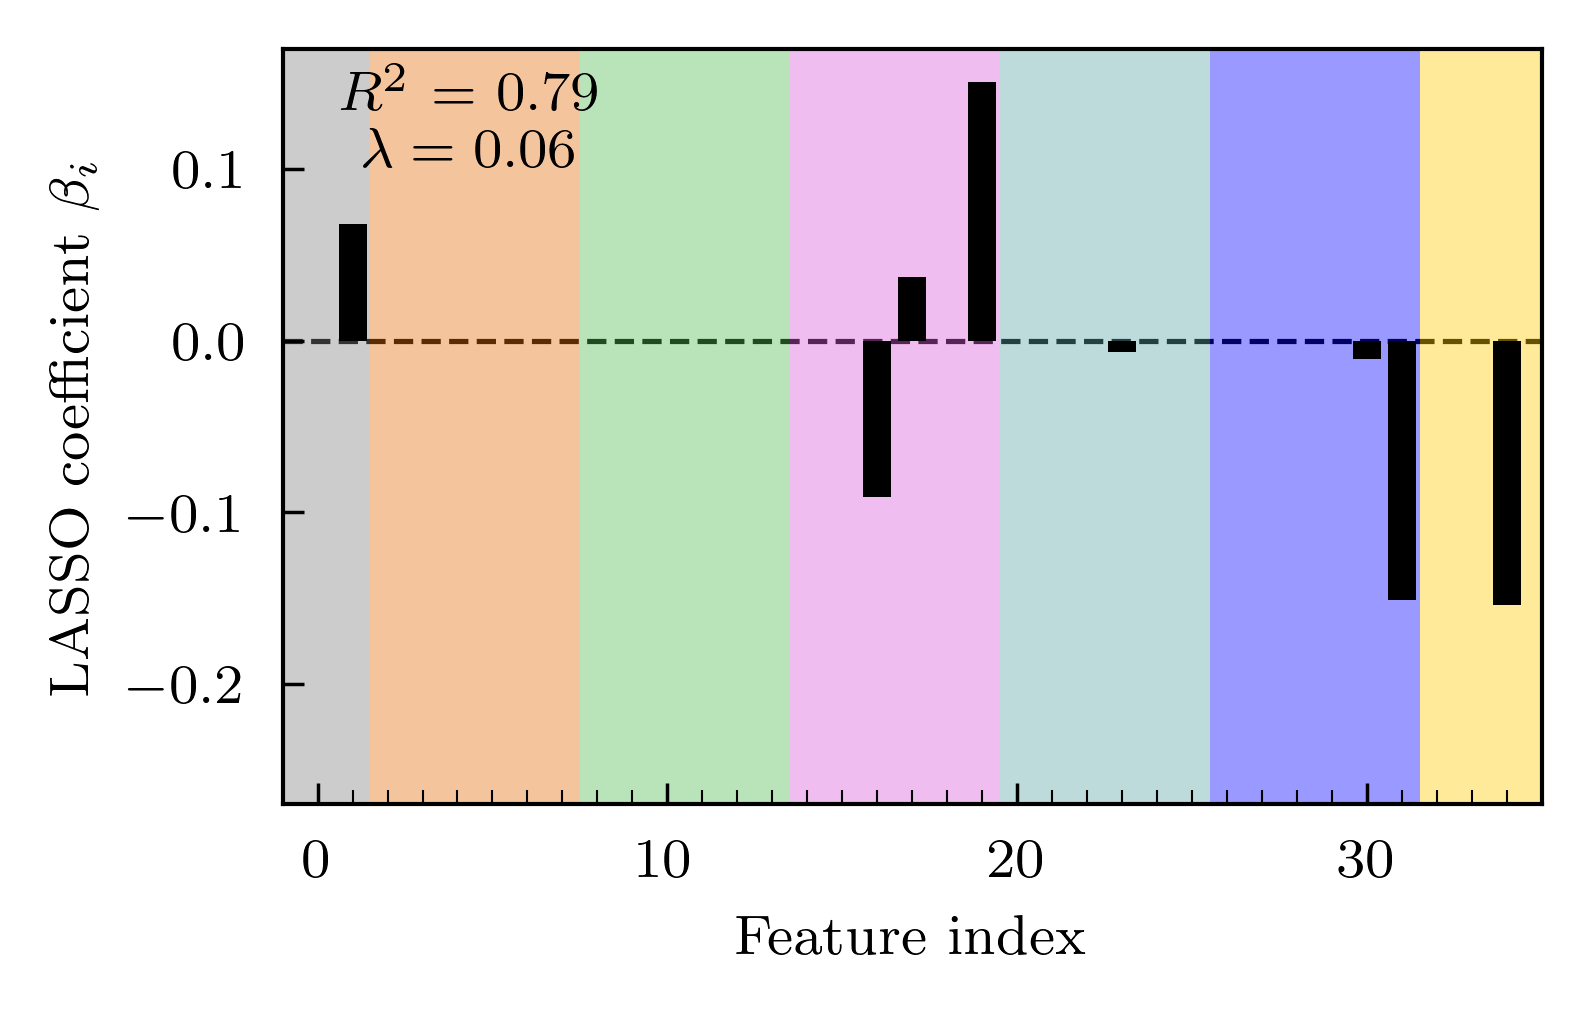

In [56]:
# alpha = 0.06
f = plt.figure(figsize=(3.25, 2), dpi=500)
ax = plt.gca()
ax.bar(np.arange(X.shape[-1]), coeffs_all[2], color='black', zorder=5)
ax.set_xlabel("Feature index")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
ax.set_xlim([-1, 35])
ax.set_ylim([-0.27, 0.17])
ax.axhline(color='black', zorder=0, ls='--')
ppl.text(0.15, 0.9, f"$R^2$ = {r2_all[2]:.2f}\n $\\lambda = 0.06$", ax=ax, transform=ax.transAxes)
ax.xaxis.set_minor_locator(ticker.MultipleLocator())
ax.axvspan(-1, 1.5, alpha=0.4, color=feature_colors[0], ec=None)
ax.axvspan(1.5, 7.5, alpha=0.4, color=feature_colors[1], ec=None)
ax.axvspan(7.5, 13.5, alpha=0.4, color=feature_colors[2], ec=None)
ax.axvspan(13.5, 19.5, alpha=0.4, color=feature_colors[3], ec=None)
ax.axvspan(19.5, 25.5, alpha=0.4, color=feature_colors[4], ec=None)
ax.axvspan(25.5, 31.5, alpha=0.4, color=feature_colors[5], ec=None)
ax.axvspan(31.5, 35, alpha=0.4, color=feature_colors[6], ec=None)